# Binary Classification with Morgan and MACCS Fingerprints

## Predicting Solubility Classes Using Decision Tree Classifiers

---

### Notebook Overview

This notebook demonstrates **binary classification** of molecular solubility using **Decision Tree Classifiers** with two different fingerprint representations: **Morgan (circular)** and **MACCS keys**. We compare their performance on the same classification task.

**Learning Objectives:**
- Apply threshold-based labeling for binary classification
- Generate and compare Morgan and MACCS fingerprints
- Train separate Decision Tree classifiers for each fingerprint type
- Evaluate classification performance using accuracy, confusion matrix, and classification report
- Compare Morgan vs MACCS fingerprints for classification tasks
- Understand trade-offs between different molecular representations

**Dataset:** ESOL-derived solubility data with SMILES strings and LogS values

**Task:** Binary classification - Predict whether a molecule is soluble or insoluble based on a LogS threshold

---

### Binary Classification Task

**Threshold Selection:**

We define solubility classes based on a LogS threshold:

- **Class 1 (Soluble):** LogS >= threshold
- **Class 0 (Insoluble):** LogS < threshold

---

### Fingerprint Comparison

We train two separate models to directly compare fingerprint performance:

**Model 1: Morgan Fingerprints**
- Circular fingerprints capturing local atomic environments
- Configurable radius and size
- More flexible and information-rich
- Higher dimensionality (typically 2048 bits)

**Model 2: MACCS Keys**
- Predefined structural keys
- Fixed 166 features
- Interpretable substructure patterns
- Lower dimensionality

**Comparison Metrics:**
- **Accuracy:** Overall correctness
- **Precision:** Of predicted soluble, how many truly soluble?
- **Recall:** Of truly soluble, how many identified?
- **F1-Score:** Harmonic mean of precision and recall
- **Confusion Matrix:** Detailed error analysis

---

### Decision Tree Classifiers

**Why Decision Trees for Classification?**

**Example decision path:**
```
Is Morgan bit 523 = 1? (substructure present?)
├─ Yes: Is bit 1047 = 1?
│   ├─ Yes: Predict SOLUBLE
│   └─ No: Is bit 89 = 1?
│       ├─ Yes: Predict SOLUBLE
│       └─ No: Predict INSOLUBLE
└─ No: Predict INSOLUBLE
```

---

## 1. Import Required Libraries

We import libraries for:
- **Data manipulation:** pandas, numpy
- **Machine Learning:** scikit-learn (DecisionTreeClassifier, metrics, train_test_split)
- **Chemical informatics:** RDKit (Chem, fingerprint generators, MACCS keys)
- **Visualization:** matplotlib, seaborn (for confusion matrix)

**Key imports for classification:**
- `DecisionTreeClassifier`: Tree-based classification model
- `accuracy_score`: Overall correctness metric
- `classification_report`: Precision, recall, F1-score
- `confusion_matrix`: Detailed error analysis
- `GetMorganGenerator`: Morgan fingerprint generation
- `MACCSkeys`: MACCS fingerprint generation

In [1]:
import pandas as pd
import numpy as np

!pip install rdkit

from rdkit import Chem
from sklearn.model_selection import train_test_split
from rdkit.Chem import MACCSkeys
from rdkit.Chem.rdFingerprintGenerator import GetMorganGenerator
from sklearn.tree import DecisionTreeClassifier, export_text
from sklearn.metrics import accuracy_score, classification_report, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

print("All libraries imported successfully!")

All libraries imported successfully!


---

## 2. Load and Prepare Dataset

### 2.1 Load Data

We load the molecular dataset containing SMILES strings and LogS values.

**Expected columns:**
- SMILES: Molecular structure notation
- LogS: Aqueous solubility (continuous values)

**Data quality checks:**
- Verify no missing SMILES
- Check LogS value distribution
- Ensure valid SMILES can be parsed

In [2]:
df = pd.read_csv('../../datasets/ESolv-Rdkit-Features.csv')
df

,Compound ID,smiles,MolWt,LogP,TPSA,HBD,HBA,RotatableBonds,FractionCSP3,Number of Rings,AromaticRings,MolRefractivity,NumHeteroatoms,NumHeavyAtoms,Minimum Degree,measured log solubility in mols per litre
0,Amigdalin,OCC3OC(OCC2OC(OC(C#N)c1ccccc1)C(O)C(O)C2O)C(O)...,457.432,-3.10802,202.32,7,12,7,0.650000,3,1,102.2816,12,32,1,-0.770
1,Fenfuram,Cc1occc1C(=O)Nc2ccccc2,201.225,2.84032,42.24,1,2,2,0.083333,2,2,57.8402,3,15,1,-3.300
2,citral,CC(C)=CCCC(C)=CC(=O),152.237,2.87800,17.07,0,1,4,0.500000,0,0,48.4860,1,11,1,-2.060
3,Picene,c1ccc2c(c1)ccc3c2ccc4c5ccccc5ccc43,278.354,6.29940,0.00,0,0,0,0.000000,5,5,96.4660,0,22,2,-7.870
4,Thiophene,c1ccsc1,84.143,1.74810,0.00,0,1,0,0.000000,1,1,24.3190,1,5,2,-1.330
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1123,halothane,FC(F)(F)C(Cl)Br,197.381,2.50850,0.00,0,0,0,1.000000,0,0,24.6230,5,7,1,-1.710
1124,Oxamyl,CNC(=O)ON=C(SC)C(=O)N(C)C,219.266,0.10710,71.00,1,5,1,0.571429,0,0,55.1847,7,14,1,0.106
1125,Thiometon,CCSCCSP(=S)(OC)OC,246.359,2.99000,18.46,0,5,7,1.000000,0,0,63.7600,6,12,1,-3.091
1126,2-Methylbutane,CCC(C)C,72.151,2.05240,0.00,0,0,1,1.000000,0,0,25.1290,0,5,1,-3.180


### 2.2 Extract SMILES and LogS Values

We extract the necessary columns for classification:
- SMILES strings for fingerprint generation
- LogS values for threshold-based labeling

In [3]:
# Extract SMILES strings from the dataframe

smiles_list = df['smiles'] 

### 2.3 Create Binary Labels

We convert continuous LogS values into binary class labels using a threshold.

**Threshold-based classification:**
- Choose a LogS threshold
- Label molecules above threshold as Class 1 (Soluble)
- Label molecules below threshold as Class 0 (Insoluble)

**Example:**
```python
# If threshold = -4:
# LogS = -3.2 → Class 1 (Soluble)
# LogS = -4.5 → Class 0 (Insoluble)
# LogS = -4.0 → Class 1 (exactly at threshold, inclusive)
```

In [4]:
# Defining a cutoff for logS classification

def classify_logS(logS):
    if logS < -6:
        return 'Low'
    elif logS >= -6:
        return 'High'   

df['LogS_Class'] = df['measured log solubility in mols per litre'].apply(classify_logS)

---

## 3. Generate Molecular Fingerprints

### 3.1 Generate Morgan Fingerprints

We generate Morgan (circular) fingerprints for all molecules.

**Morgan fingerprint configuration:**
- **Radius:** Typically 1 or 2 (check code for specific value)
- **Size:** Typically 2048 bits
- **Type:** Binary (0/1) bit vector

**Process:**
1. Parse SMILES to molecule object
2. Generate Morgan fingerprint using RDKit generator
3. Convert to numpy array
4. Stack all fingerprints into feature matrix

**Result:** X_morgan with shape (n_samples, 2048)

In [5]:
morgan_generator = GetMorganGenerator(radius=3, fpSize=2048)

def smiles_to_fingerprint(smiles):
    mol = Chem.MolFromSmiles(smiles)
    if mol:
        return morgan_generator.GetFingerprint(mol)
    else:
        return None

def smiles_to_maccs_fingerprint(smiles):
    mol = Chem.MolFromSmiles(smiles)
    if mol:
        fp = MACCSkeys.GenMACCSKeys(mol)
        return np.array(fp)
    else:
        return None

### 3.2 Convert Morgan Fingerprints to Array

We convert the list of Morgan fingerprints to a numpy array suitable for scikit-learn.

In [6]:
# Convert the fingerprints list to numpy array for model input

fingerprints = [smiles_to_fingerprint(s) for s in smiles_list]
valid_idx = [i for i, fp in enumerate(fingerprints) if fp is not None]
fingerprints = [fingerprints[i] for i in valid_idx]
labels = df.iloc[valid_idx]['LogS_Class'].values

maccs_fps = [smiles_to_maccs_fingerprint(s) for s in smiles_list]
valid_idx_m = [i for i, fp in enumerate(maccs_fps) if fp is not None]
maccs_fps = [maccs_fps[i] for i in valid_idx_m]
labels_m = df.iloc[valid_idx_m]['LogS_Class'].values

---

## 4. Train and Evaluate Classification Models

### 4.1 Model 1: Decision Tree with Morgan Fingerprints

We train a Decision Tree classifier using Morgan fingerprints.

**Training process:**
1. Split data into train/test (typically 80/20)
2. Initialize DecisionTreeClassifier
3. Fit model on training data (X_train_morgan, y_train)
4. Generate predictions on test set
5. Evaluate performance

**Evaluation metrics:**

**Accuracy:**
- Formula: (TP + TN) / (TP + TN + FP + FN)
- Interpretation: Overall percentage correct
- Good for balanced classes

**Precision (for Soluble class):**
- Formula: TP / (TP + FP)
- Interpretation: Of predicted soluble, how many are truly soluble?
- Important when false positives costly

**Recall (for Soluble class):**
- Formula: TP / (TP + FN)
- Interpretation: Of truly soluble, how many did we identify?
- Important when false negatives costly

**F1-Score:**
- Formula: 2 × (Precision × Recall) / (Precision + Recall)
- Interpretation: Harmonic mean balancing precision and recall
- Good overall metric

**Confusion Matrix:**
```
                 Predicted
              Insol  Soluble
Actual Insol   TN      FP
       Sol     FN      TP
```

Test set accuracy: 0.9027

Classification report:
              precision    recall  f1-score   support

        High       0.93      0.96      0.95       201
         Low       0.58      0.44      0.50        25

    accuracy                           0.90       226
   macro avg       0.76      0.70      0.72       226
weighted avg       0.89      0.90      0.90       226



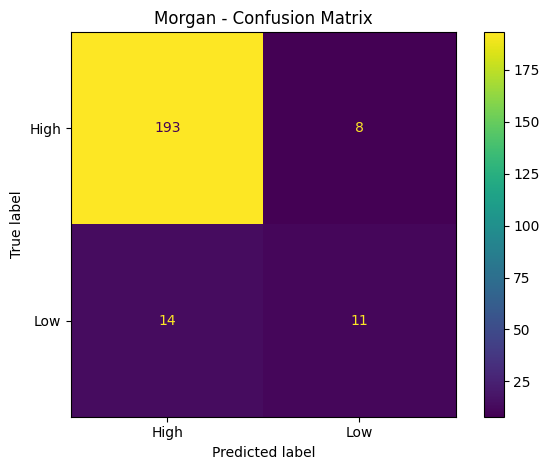

In [7]:
X = np.array([np.array(fp) for fp in fingerprints])
y = labels

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

clf = DecisionTreeClassifier(random_state=42)
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)

acc = accuracy_score(y_test, y_pred)
print(f"Test set accuracy: {acc:.4f}")
print("\nClassification report:")
print(classification_report(y_test, y_pred))

ConfusionMatrixDisplay.from_predictions(y_test, y_pred)
plt.title("Morgan - Confusion Matrix")
plt.tight_layout()
plt.show()

### 4.2 Model 2: Decision Tree with MACCS Fingerprints

We train a separate Decision Tree classifier using MACCS keys for comparison.

**MACCS fingerprints:**
- 166 predefined structural keys
- Lower dimensionality than Morgan
- More interpretable features
- Faster computation

**Comparison goal:**
- Evaluate if higher-dimensional Morgan (2048) outperforms MACCS (166)
- Assess trade-off between information content and dimensionality
- Determine which fingerprint type better captures solubility patterns

MACCS Test set accuracy: 0.9336

MACCS Classification report:
              precision    recall  f1-score   support

        High       0.95      0.98      0.96       201
         Low       0.78      0.56      0.65        25

    accuracy                           0.93       226
   macro avg       0.86      0.77      0.81       226
weighted avg       0.93      0.93      0.93       226



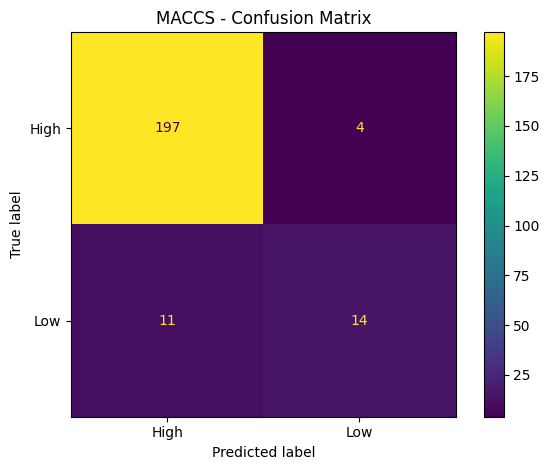

In [8]:
X_c = np.array(maccs_fps)
y_c = labels_m

X_train_c, X_test_c, y_train_c, y_test_c = train_test_split(
    X_c, y_c, test_size=0.2, random_state=42
)

clf_c = DecisionTreeClassifier(random_state=42)
clf_c.fit(X_train_c, y_train_c)
y_pred_c = clf_c.predict(X_test_c)
acc_c = accuracy_score(y_test_c, y_pred_c)
print(f"MACCS Test set accuracy: {acc_c:.4f}")
print("\nMACCS Classification report:")
print(classification_report(y_test_c, y_pred_c))

ConfusionMatrixDisplay.from_predictions(y_test_c, y_pred_c)
plt.title("MACCS - Confusion Matrix")
plt.tight_layout()
plt.show()


---

## 5. Results Analysis and Interpretation

### 5.1 Understanding the Results

The output above shows classification performance for both fingerprint types. Let's interpret the metrics:

**Classification Report Interpretation:**

```
              precision    recall  f1-score   support
           0       0.XX      0.XX      0.XX       XXX  (Insoluble class)
           1       0.XX      0.XX      0.XX       XXX  (Soluble class)
    accuracy                           0.XX       XXX  (Overall)
```

**For each class:**
- **Precision:** How reliable are predictions of this class?
- **Recall:** How many of this class did we find?
- **F1-score:** Overall quality for this class
- **Support:** Number of samples in test set

**Good performance indicators:**
- Accuracy > 0.80 (80%)
- F1-scores > 0.75 for both classes
- Precision and recall balanced (not too different)
- Confusion matrix shows low off-diagonal values

### 5.2 Confusion Matrix Metrics

The confusion matrix reveals specific error patterns:

**Structure:**
```
[[TN  FP]   True Negatives  |  False Positives
 [FN  TP]]  False Negatives |  True Positives
```

**Key insights:**

**High TN (True Negatives):**
- Model correctly identifies insoluble compounds
- Good for filtering out poor solubility candidates

**High TP (True Positives):**
- Model correctly identifies soluble compounds
- Good for finding viable drug candidates

**High FP (False Positives):**
- Model predicts soluble but actually insoluble
- Risk: Advancing poor candidates
- Solution: Increase precision (stricter threshold)

**High FN (False Negatives):**
- Model predicts insoluble but actually soluble
- Risk: Missing good candidates
- Solution: Increase recall (lower threshold

### 5.3 Confusion Matrix Insights

- The Decision Tree classifier shows:
  - High accuracy for predicting **High solubility** compounds.
  - Poor recall for **Low solubility** class — many are misclassified as High.
  - This imbalance is evident in the confusion matrix (e.g., 193 High correctly predicted vs. only 11 Low).

- The **MACCS fingerprint-based** model performs slightly better for Low class but still shows similar bias.



### 5.4 Data Imbalance as Root Cause

- On examining the logS distribution, we see:
  - **Most molecules have logS > -6**, making the “High” class over-represented.
  - The classification threshold (logS = -6) causes a heavy skew toward the High label.

- This class imbalance leads the decision tree to **favor the dominant class** (High) to maximize accuracy.


### 5.6 Final Comparison

Display side-by-side accuracy comparison:

In [9]:
print(f"Morgan Accuracy: {acc:.4f}   |   MACCS Accuracy: {acc_c:.4f}")

Morgan Accuracy: 0.9027   |   MACCS Accuracy: 0.9336
